In [ ]:
import nextnanopy as nn
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# base_file_path = r"C:\Users\splatt\Documents\nextnano\Output\InGaAsInAlAs_6nm_valence_band_anticrossing_check_sweep_template\InGaAsInAlAs_6nm_valence_band_anticrossing_check_sweep_template.nnp"
base_filename = 'barrier_sweep'
parent_dir = r'C:\Users\splatt\nextnanopy_projects\InGaAsInAlAssinglewell'

input_filepath = os.path.join(parent_dir, base_filename + '.nnp')
base_file_input = nn.InputFile(input_filepath,product='nextnano++')

print(base_file_input)

In [ ]:
#setup sweep
barrier_widths = [1.0,2.0,5.0,10.0,20.0]
sweep_variable = 'w_middle_barrier'  
barrier_sweep  = nn.Sweep({sweep_variable:barrier_widths},input_filepath)
barrier_sweep.save_sweep()
barrier_sweep.input_files


In [ ]:
barrier_sweep.execute_sweep(overwrite = True, show_log = True)


In [ ]:
class SweepOut:
    def __init__(self, sweepvar):
        self.sweep_var_value = sweepvar
        self.Gamma = None
        self.HH = None
        self.LH = None
        self.CB_subband_probs = None
        self.VB_subband_probs = None
        self.E_CB = None
        self.E_VB = None

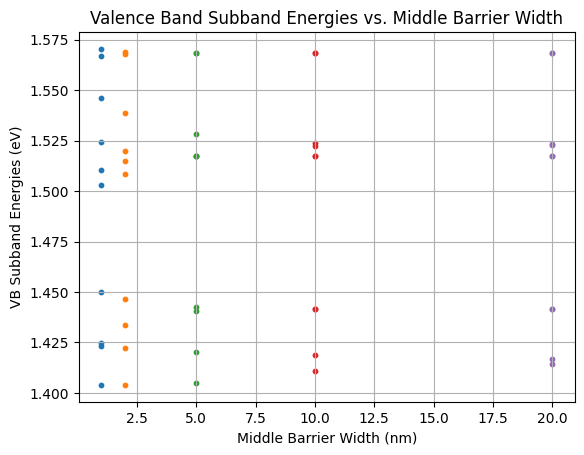

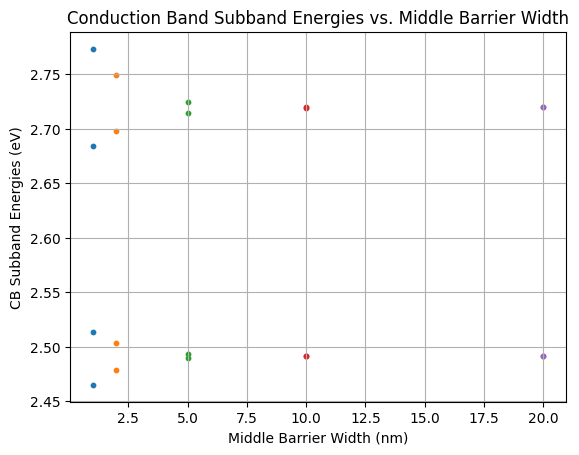

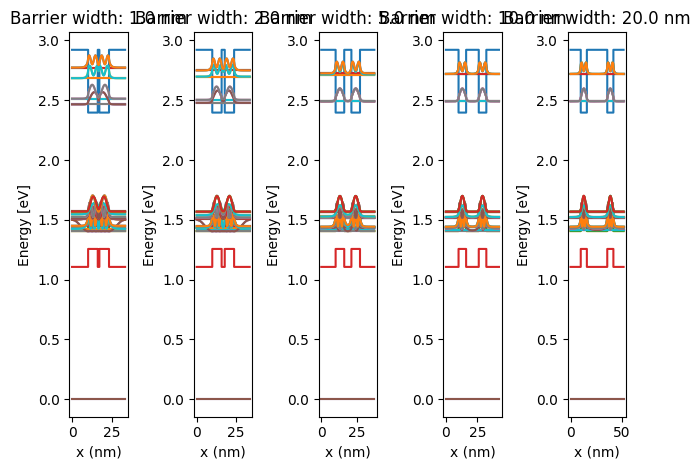

In [113]:
#now load in each of those sweeps and extract the E1 and E2
all_sweep_outs = dict()
fig_compare_VB,ax_compare_VB = plt.subplots()
fig_compare_CB,ax_compare_CB = plt.subplots()
fig,axs = plt.subplots(1,len(barrier_widths))
filebase_output = nn.config.get('nextnano++','outputdirectory')
#extract E1 and E2 from each sweep and plot
VB_cutoff = 2
bias = r'bias_00000'
quantum_subfolder = r'Quantum\quantum_region\kp8'
for barrier_ind in range(0,len(barrier_widths)):
    #extract the file
    bw = barrier_widths[barrier_ind]
    sweep_bar = SweepOut(sweepvar=barrier_widths[barrier_ind])
    barrier_ind_outpath = os.path.join(barrier_sweep.input_files[barrier_ind].folder_output,bias)

    band_edge = nn.DataFile(os.path.join(barrier_ind_outpath, 'bandedges.dat'),'nextnano++')
    sweep_bar.Gamma = band_edge.variables['Gamma']
    sweep_bar.HH = band_edge.variables['HH']
    sweep_bar.LH = band_edge.variables['LH']

    quantum_sims_path = os.path.join(barrier_ind_outpath, quantum_subfolder)
    energy_spectrum = nn.DataFile(os.path.join(quantum_sims_path, 'energy_spectrum_k00000.dat'),'nextnano++')
    probabilities = nn.DataFile(os.path.join(quantum_sims_path, 'probabilities_shift_k00000.dat'),'nextnano++')

    
    # Plot band edges
    for band_edge_var in band_edge.variables:
          
          axs[barrier_ind].plot(band_edge.coords['x'].value,band_edge_var.value, label=band_edge_var.name)

    # Plot wavefunction probabilities
    non_degen_probabilities_CB = []
    non_degen_probabilities_VB = []
    non_degen_E = []
    non_degen_E_CB = []
    non_degen_E_VB = []

    non_degen_E_CB_inds = []
    non_degen_E_VB_inds = []

    for psi in probabilities.variables:
        parts = psi.name.split('_')
        if len(parts) > 1 and parts[-1].isdigit():
            num = int(parts[-1])
            if num % 2 == 1:  # odd numbe
                if 'E' in psi.name:
                    non_degen_E.append(np.mean(psi.value))
                    if np.mean(psi.value) < VB_cutoff:
                        non_degen_E_VB.append(np.mean(psi.value))  # Plot only for E < 0.5 eV
                        non_degen_E_VB_inds.append(num)
                    else:
                        non_degen_E_CB.append(np.mean(psi.value))
                        non_degen_E_CB_inds.append(num)


    for psi in probabilities.variables:
        if 'Psi^2' in psi.name:
            psiind = int(psi.name.split('_')[-1])
            if psiind in non_degen_E_CB_inds:
                non_degen_probabilities_CB.append(psi.value)
            if psiind in non_degen_E_VB_inds:
                non_degen_probabilities_VB.append(psi.value)
        axs[barrier_ind].plot(probabilities.coords['x'].value, psi.value, label=psi.name)

    sweep_bar.CB_subband_probs = non_degen_probabilities_CB
    sweep_bar.VB_subband_probs = non_degen_probabilities_VB
    sweep_bar.E_CB = non_degen_E_CB
    sweep_bar.E_VB = non_degen_E_VB

    axs[barrier_ind].set_title(f"Barrier width: {barrier_widths[barrier_ind]} nm")
    axs[barrier_ind].set_xlabel('x (nm)')
    axs[barrier_ind].set_ylabel('Energy [eV]')

    if len(sweep_bar.E_VB) > 0:
        x_vb = np.full(len(sweep_bar.E_VB), bw, dtype=float)
        ax_compare_VB.scatter(x_vb, sweep_bar.E_VB, s=10, label=f'{bw} nm')

    if len(sweep_bar.E_CB) > 0:
        x_cb = np.full(len(sweep_bar.E_CB), bw, dtype=float)
        ax_compare_CB.scatter(x_cb, sweep_bar.E_CB, s=10, label=f'{bw} nm')

    all_sweep_outs[barrier_widths[barrier_ind]] = sweep_bar
#     axs.legend()

ax_compare_CB.grid(True)
ax_compare_VB.grid(True)

ax_compare_VB.set_xlabel('Middle Barrier Width (nm)')
ax_compare_VB.set_ylabel('VB Subband Energies (eV)')
ax_compare_VB.set_title('Valence Band Subband Energies vs. Middle Barrier Width')
ax_compare_CB.set_xlabel('Middle Barrier Width (nm)')
ax_compare_CB.set_ylabel('CB Subband Energies (eV)')
ax_compare_CB.set_title('Conduction Band Subband Energies vs. Middle Barrier Width')
plt.tight_layout()
plt.show()

    
